# EMNIST

## Parameters

In [1]:
from pathlib import Path

# Directorio del csv
BASE_DIR = Path('/Users/efraflores/Desktop/EF/Diplo/data/04/pokemon')
# Directorio de las imágenes
IMAGES_DIR = BASE_DIR.joinpath('images')
# Nombre del csv
FILE_NAME = 'pokemon.csv'
# Se va a crear una columna con el nombre de la imagen
PATH_COL = 'filename'
# Si un pokemon tiene dos tipos, se harán dos renglones con cada clase
LABEL_COL = 'class'

## Functions

### Timing and tone

In [2]:
import time
import numpy as np
from IPython.lib.display import Audio

start = time.time()
def time_exp(x):
    #Just print how many minutes and seconds have passed
    minutes, seconds = np.floor(x/60), 60*(x/60-np.floor(x/60))
    print(f"{'{:.0f}'.format(minutes)} minutos con {'{:.2f}'.format(seconds)} segundos")
    
def tone(a=1000, b=700, play_time_seconds=1, framerate=4410):
    #Make a sound! Useful while training models
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t)+np.sin(b*t), rate=framerate, autoplay=True)

### Show pokemon

In [3]:
from PIL import Image

def show_pokemon(pokemon='pikachu', filepath='images', ext='png'):
    img = Image.open(Path(filepath).joinpath(f'{pokemon}.{ext}'))
    return img

### Blur image

In [4]:
#!pip install opencv-python
import cv2
def blur(img):
    return cv2.GaussianBlur(np.asarray(img), ksize=(5,5), sigmaX=0)

### Images from DataFrame

In [24]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

def images_from_df(data, **kwargs):
    
    df = data.copy()
    X_train, X_test = train_test_split(df, train_size=0.8, random_state=22)

    train_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=blur, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, rotation_range=45)

    training_set = train_gen.flow_from_dataframe(dataframe=X_train, **kwargs)
    testing_set = ImageDataGenerator(rescale=1./255).flow_from_dataframe(dataframe=X_test, **kwargs)
    
    print('\n These are the classes:\n',training_set.class_indices)
    return training_set, testing_set

### CNN builder

In [6]:
from keras import Input
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, LeakyReLU

def cnn_sequential_builder(train_set, layer_filters, cnn_activ, layer_units, seq_activ):
    n_classes = len(train_set.class_indices)

    model = Sequential()
    model.add(Conv2D(filters=n_classes*10, kernel_size=2, input_shape=train_set.image_shape, activation='relu'))
    
    for filters,activ in zip(layer_filters, cnn_activ):
        model.add(Conv2D(filters, 3, activation=activ))
        model.add(MaxPool2D(pool_size=3, strides=1))
    
    model.add(Flatten())
    
    for units,activa in zip(layer_units, seq_activ):
        model.add(Dense(units, activa))
    
    last_layer,last_activ = (1,'sigmoid') if n_classes<=2 else (n_classes,'softmax')
    model.add(Dense(last_layer, last_activ))
    
    print(model.summary())
    return model

### Plot metrics

In [34]:
import matplotlib.pyplot as plt

def plot_metrics(training_history,metrics=['accuracy','loss']):
    #Show the trend of every metrics provided after training
    for metric in metrics:
        trend = training_history.history[metric]
        plt.figure()
        plt.plot(range(len(trend)), trend, 'r', label=f'Training {metric}')
        plt.title(f'Training {metric}')
    plt.show()

### Confussion Matrix KERAS

In [59]:
def cm_keras(X, y, fit_model, label_encod=None):
    y_real = [np.argmax(x) for x in y]
    y_predicted = [np.argmax(x).reshape(-1,)[0] for x in fit_model.predict(X)]

    if label_encod == None: pass
    else: 
        y_real = label_encod.inverse_transform(y_real)
        y_predicted = label_encod.inverse_transform(y_predicted)

    cm = pd.DataFrame(confusion_matrix(y_true=y_real, y_pred=y_predicted),
                    index=label_encod.classes_ if label_encod!=None else label_encod,
                    columns=label_encod.classes_ if label_encod!=None else label_encod).replace({0:np.nan}).T

    print('Accuracy de {:.2%}'.format(np.asarray(cm).trace()/len(y_test)))
    size = int(len(np.unique(y_real))/2)
    fig, ax = plt.subplots(figsize=(size,size)) 
    sns.heatmap(pd.DataFrame([cm[col]/cm[col].sum() for col in cm.columns]), 
                annot = True,
                fmt = '.0%',
                cmap = 'Blues',
                linewidths = 0.5, 
                ax = ax)
    plt.show()
    return cm

### Predict letter from image KERAS

In [9]:
def predict_letter_keras(base_dir, image_list, fit_model, prep=None, label_encod=None):
    aux = []
    for img in image_list:
        letter = Image.open(base_dir.joinpath(img)).convert('L').resize((28,28))
        flat = -(1+np.asarray(letter)).ravel()
        aux.append(flat)

    if prep == None: pass
    else: aux = prep.transform(pd.DataFrame(aux))

    prediction = fit_model.predict(aux)
    word = [np.argmax(x).reshape(-1,)[0] for x in prediction]

    if label_encod == None: pass
    else: word = label_encod.inverse_transform(word)

    word = ''.join(word)

    fig, axes = plt.subplots(1, len(word), figsize=(15, 5), sharey=True)
    for i,row in enumerate(aux):
        row = row if prep==None else prep.inverse_transform(row.reshape(1,-1))
        sns.heatmap(pd.DataFrame(row.reshape((28,28))), ax=axes[i], cbar=False, xticklabels=False, yticklabels=False)
    plt.subplots_adjust(wspace=.001)
    plt.show()
    print(f'The word predicted is: {word}')

## Data Wrangling

### Import

In [7]:
import pandas as pd

# Importar csv como DataFrame
df = pd.read_csv(BASE_DIR.joinpath(FILE_NAME))
df.sample()

,Name,Type1,Type2
734,gumshoos,Normal,NaN


### All images in .jpg

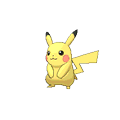

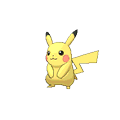

In [18]:
png = show_pokemon(filepath=IMAGES_DIR).convert('RGBA')
png.load()
jpg = Image.new("RGB", png.size, (255, 255, 255))
jpg.paste(png, mask=png.split()[3])
display(png, jpg)

In [19]:
import shutil

BASE_DIR.joinpath('images_correct').mkdir()
for x in df['Name']:
    if IMAGES_DIR.joinpath(f'{x}.jpg').exists():
        shutil.copy(IMAGES_DIR.joinpath(f'{x}.jpg'),BASE_DIR.joinpath('images_correct',f'{x}.jpg'))
    else:
        png = Image.open(IMAGES_DIR.joinpath(f'{x}.png')).convert('RGBA')
        png.load()
        background = Image.new("RGB", png.size, (255, 255, 255))
        background.paste(png, mask=png.split()[3])
        background.save(BASE_DIR.joinpath('images_correct',f'{x}.jpg'), 'JPEG', quality=100)
IMAGES_DIR = BASE_DIR.joinpath('images_correct')

### Filename column

In [20]:
# Crear la columna, hay archivos png y jpg
df[PATH_COL] = df['Name'].apply(lambda x: f'{x}.jpg')
df.set_index('Name', inplace=True)
df.sample()

,Type1,Type2,filename
Name,,,
umbreon,Dark,NaN,umbreon.jpg


### Just one column-label

In [21]:
# Si tiene dos tipos, se agrega otro renglón con el segundo tipo
df = df.melt(id_vars=PATH_COL, value_vars=['Type1','Type2'], ignore_index=False)
# Se ajustan columnas
df = df.rename({'value':LABEL_COL}, axis=1).drop('variable', 1).dropna()
df.sample()

,filename,class
Name,,
jirachi,jirachi.jpg,Psychic


### Image Data Generator

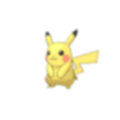

In [22]:
Image.fromarray(blur(jpg))

In [25]:
train, test = images_from_df(df, directory=IMAGES_DIR, target_size=(120,120))

Found 971 validated image filenames belonging to 18 classes.
Found 243 validated image filenames belonging to 18 classes.

 These are the classes:
 {'Bug': 0, 'Dark': 1, 'Dragon': 2, 'Electric': 3, 'Fairy': 4, 'Fighting': 5, 'Fire': 6, 'Flying': 7, 'Ghost': 8, 'Grass': 9, 'Ground': 10, 'Ice': 11, 'Normal': 12, 'Poison': 13, 'Psychic': 14, 'Rock': 15, 'Steel': 16, 'Water': 17}


## Model

In [26]:
model = cnn_sequential_builder(train,[2],['relu'],[2],['relu'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 119, 119, 180)     2340      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 117, 2)       3242      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 115, 115, 2)       0         
_________________________________________________________________
flatten (Flatten)            (None, 26450)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 52902     
_________________________________________________________________
dense_1 (Dense)              (None, 18)                54        
Total params: 58,538
Trainable params: 58,538
Non-trainable params: 0
____________________________________________________

2021-08-07 18:37:30.229370: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Compile

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

### Callbacks

#### Early Stopping

In [29]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20)

#### Checkpoints

In [31]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',
                               save_best_only=True,
                               save_weights_only=False,
                               monitor='val_accuracy')

### Training

#### Fit

In [32]:
train_history = model.fit(train, validation_data=test, epochs=2, callbacks=[early_stopping, checkpoint])

2021-08-07 18:38:00.341414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
31/31 [==============================] - 88s 2s/step - loss: 2.8965 - accuracy: 0.0942 - val_loss: 2.8872 - val_accuracy: 0.1235
Epoch 2/2
31/31 [==============================] - 73s 2s/step - loss: 2.8837 - accuracy: 0.1103 - val_loss: 2.8847 - val_accuracy: 0.1235


#### Metrics

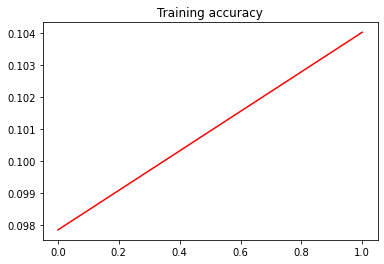

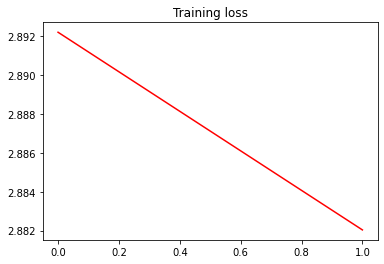

In [35]:
plot_metrics(train_history)

### Confussion Matrix

Accuracy de 88.76%


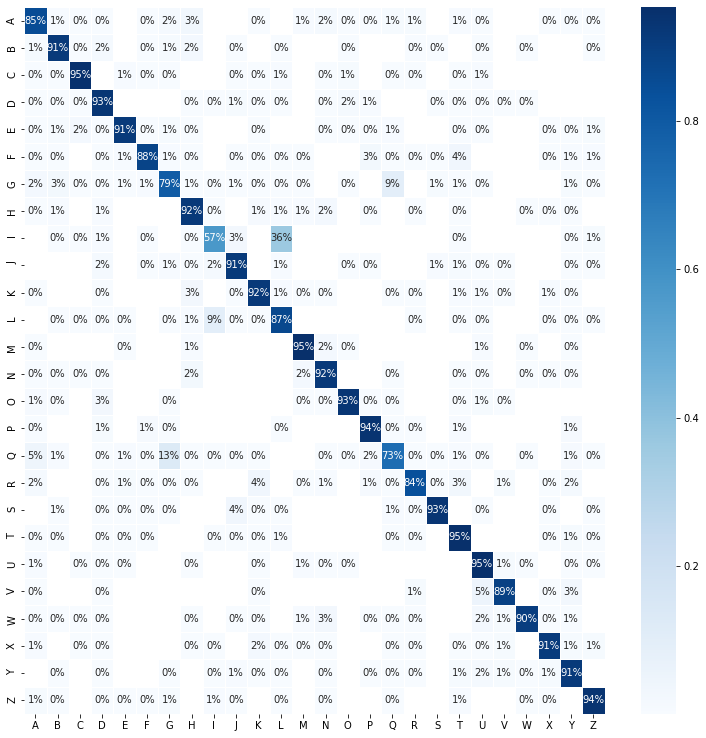

In [66]:
keras_cm = cm_keras(X_ann_test, y_ann_test, model_ann, le)

### From images

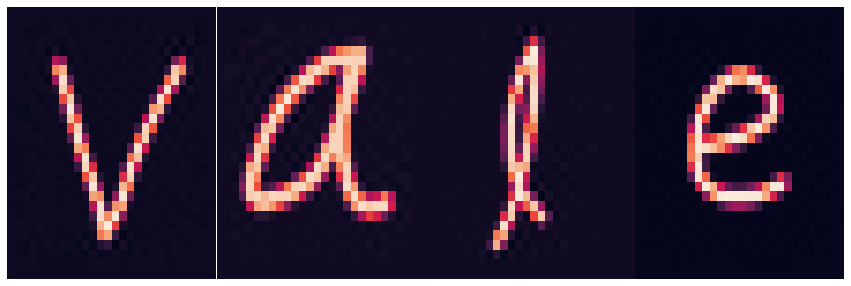

The word predicted is: VALC


In [67]:
predict_letter_keras(BASE_DIR.joinpath('images'), IMAGES, model_ann, prep_ann, le)

### Export

In [72]:
model_ann.save(BASE_DIR.joinpath('letters_model.h5'))

In [73]:
import h5py
from keras.models import load_model
new_model = load_model(BASE_DIR.joinpath('letters_model.h5'))
f = h5py.File(BASE_DIR.joinpath('letters_model.h5'), 'r')
print(list(f.keys()))

['model_weights', 'optimizer_weights']


## End

In [33]:
time_exp(time.time() - start)
tone()

32 minutos con 21.26 segundos
